<a href="https://colab.research.google.com/github/EdwardFang09/questionable-youtube-video-title/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch  # Import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
!nvidia-smi

Wed Dec 11 23:24:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Training

In [18]:
# Import necessary libraries
import pandas as pd  # For data manipulation
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer  # For using the GPT-2 model and training
import torch  # For deep learning operations
from sklearn.model_selection import train_test_split  # For splitting data

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset from a CSV file
df = pd.read_csv("youtube_data.csv")

# ---- only use higher views than average ----------------------------
# Calculate the average views
average_views = df['views'].mean()

# Filter the DataFrame to keep only rows where 'views' is greater than the average
df = df[df['views'] > average_views]
# ---------------------------------------------------------------------------

# Convert non-string values in 'video_title' column to strings
df['video_title'] = df['video_title'].fillna('').astype(str)

# Split data into training and evaluation sets (80% train, 20% eval)
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42) #random_state=42

# Extract video titles for training and evaluation
train_titles = train_df['video_title'].tolist()
eval_titles = eval_df['video_title'].tolist()

# Initialize tokenizer and model
model_name = "gpt2"  # Jika mau menggunakan gpt2 (model dasar)
# model_name = "EdwardFang09/QuestionableYouTubeVideoTitleV1"  # Path to your initial fine-tuned model#
# model_name = "QuestionableYouTubeVideoTitleV1_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load the tokenizer

# Add a padding token (often set to EOS token for language models)
tokenizer.pad_token = tokenizer.eos_token

# Load the pre-trained GPT-2 model
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)  # Move the model to the appropriate device

# Prepare the dataset for training
class TitlesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings  # Store the tokenized encodings

    def __getitem__(self, idx):
        # Retrieve encoded data and create labels (targets)
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = item["input_ids"].clone()  # Labels are the same as input IDs for language modeling
        return item

    def __len__(self):
        return len(self.encodings.input_ids)  # Return the length of the dataset

# Tokenize the titles for training and evaluation
train_encodings = tokenizer(train_titles, truncation=True, padding=True)  # Truncate long titles and pad shorter ones
eval_encodings = tokenizer(eval_titles, truncation=True, padding=True)

# Create dataset objects
train_dataset = TitlesDataset(train_encodings)
eval_dataset = TitlesDataset(eval_encodings)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save training outputs
    num_train_epochs=10,  # Number of training epochs
    per_device_train_batch_size=256,  # Batch size per device
    save_steps=100000,  # Save checkpoints every 1000 steps
    logging_dir="./logs",  # Directory for training logs
    logging_steps=100000,  # Log every 100 steps  # Added logging_steps
    fp16=True,  # Enable mixed precision training (if supported)
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch
    load_best_model_at_end=True,  # Load the best performing model at the end of training
    # Since we're removing BLEU, we'll use loss to determine the best model
    metric_for_best_model="loss",
)

# Define the Trainer
trainer = Trainer(
    model=model,  # The GPT-2 model to be fine-tuned
    args=training_args,  # Training arguments
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=eval_dataset,  # Evaluation dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model and tokenizer
trainer.save_model("./QuestionableYouTubeVideoTitleV1_finetuned2")  # Save the model
tokenizer.save_pretrained("./QuestionableYouTubeVideoTitleV1_finetuned2")  # Save the tokenizer

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.249338
2,No log,1.247376
3,No log,1.287058
4,No log,1.261602
5,No log,1.245688
6,No log,1.227185
7,No log,1.221042
8,No log,1.214257
9,No log,1.214073
10,No log,1.217196


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


('./QuestionableYouTubeVideoTitleV1_finetuned2/tokenizer_config.json',
 './QuestionableYouTubeVideoTitleV1_finetuned2/special_tokens_map.json',
 './QuestionableYouTubeVideoTitleV1_finetuned2/vocab.json',
 './QuestionableYouTubeVideoTitleV1_finetuned2/merges.txt',
 './QuestionableYouTubeVideoTitleV1_finetuned2/added_tokens.json',
 './QuestionableYouTubeVideoTitleV1_finetuned2/tokenizer.json')

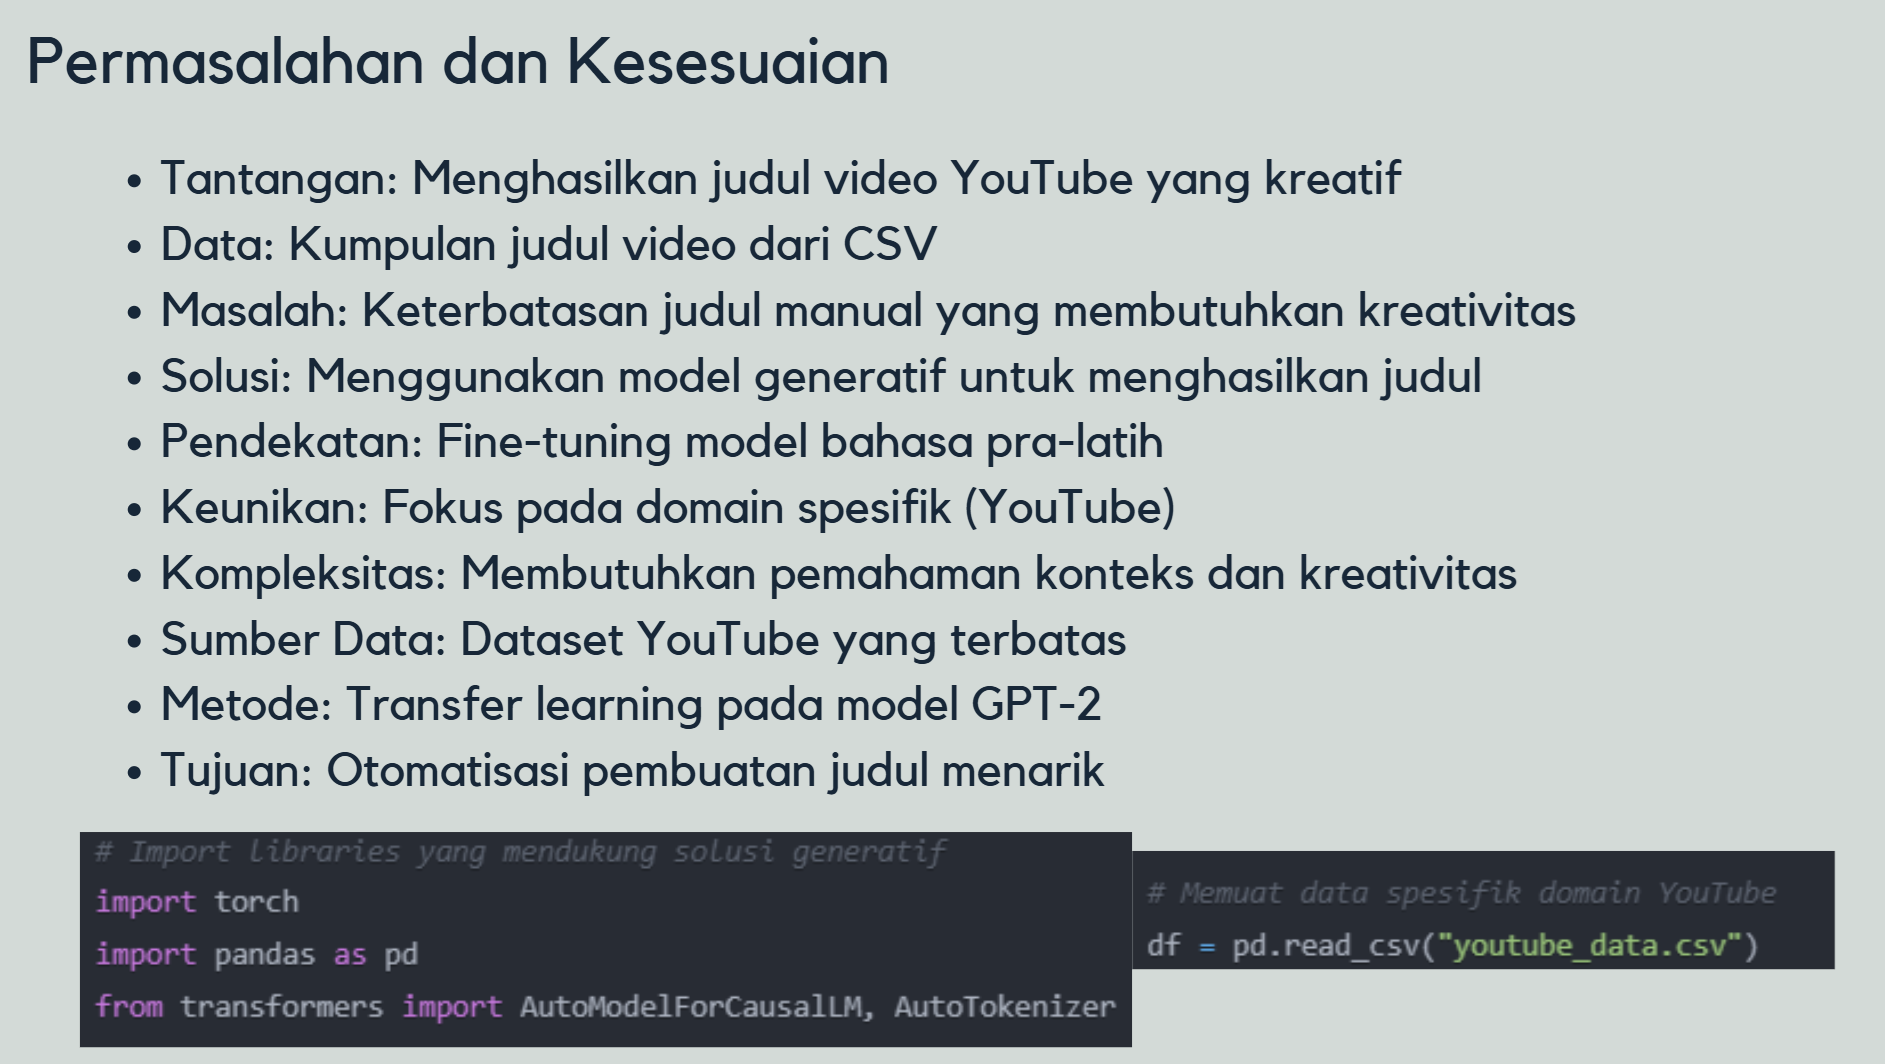

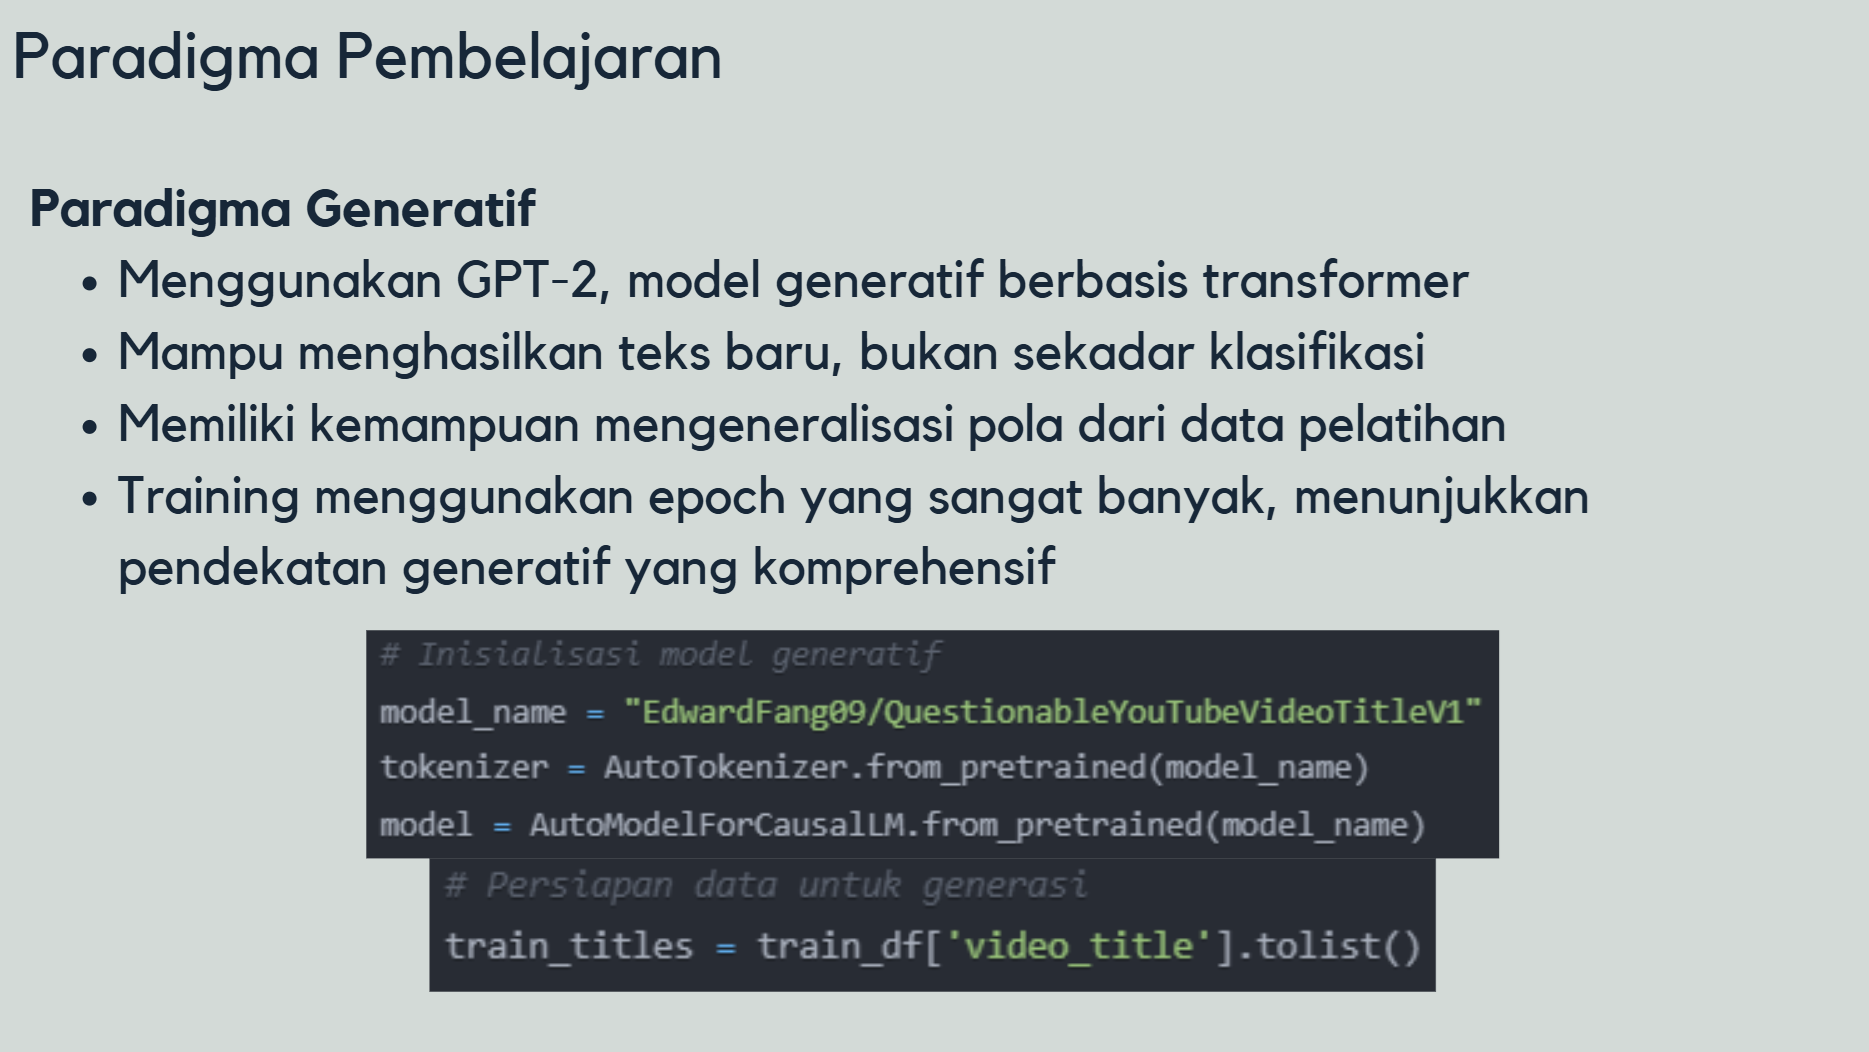

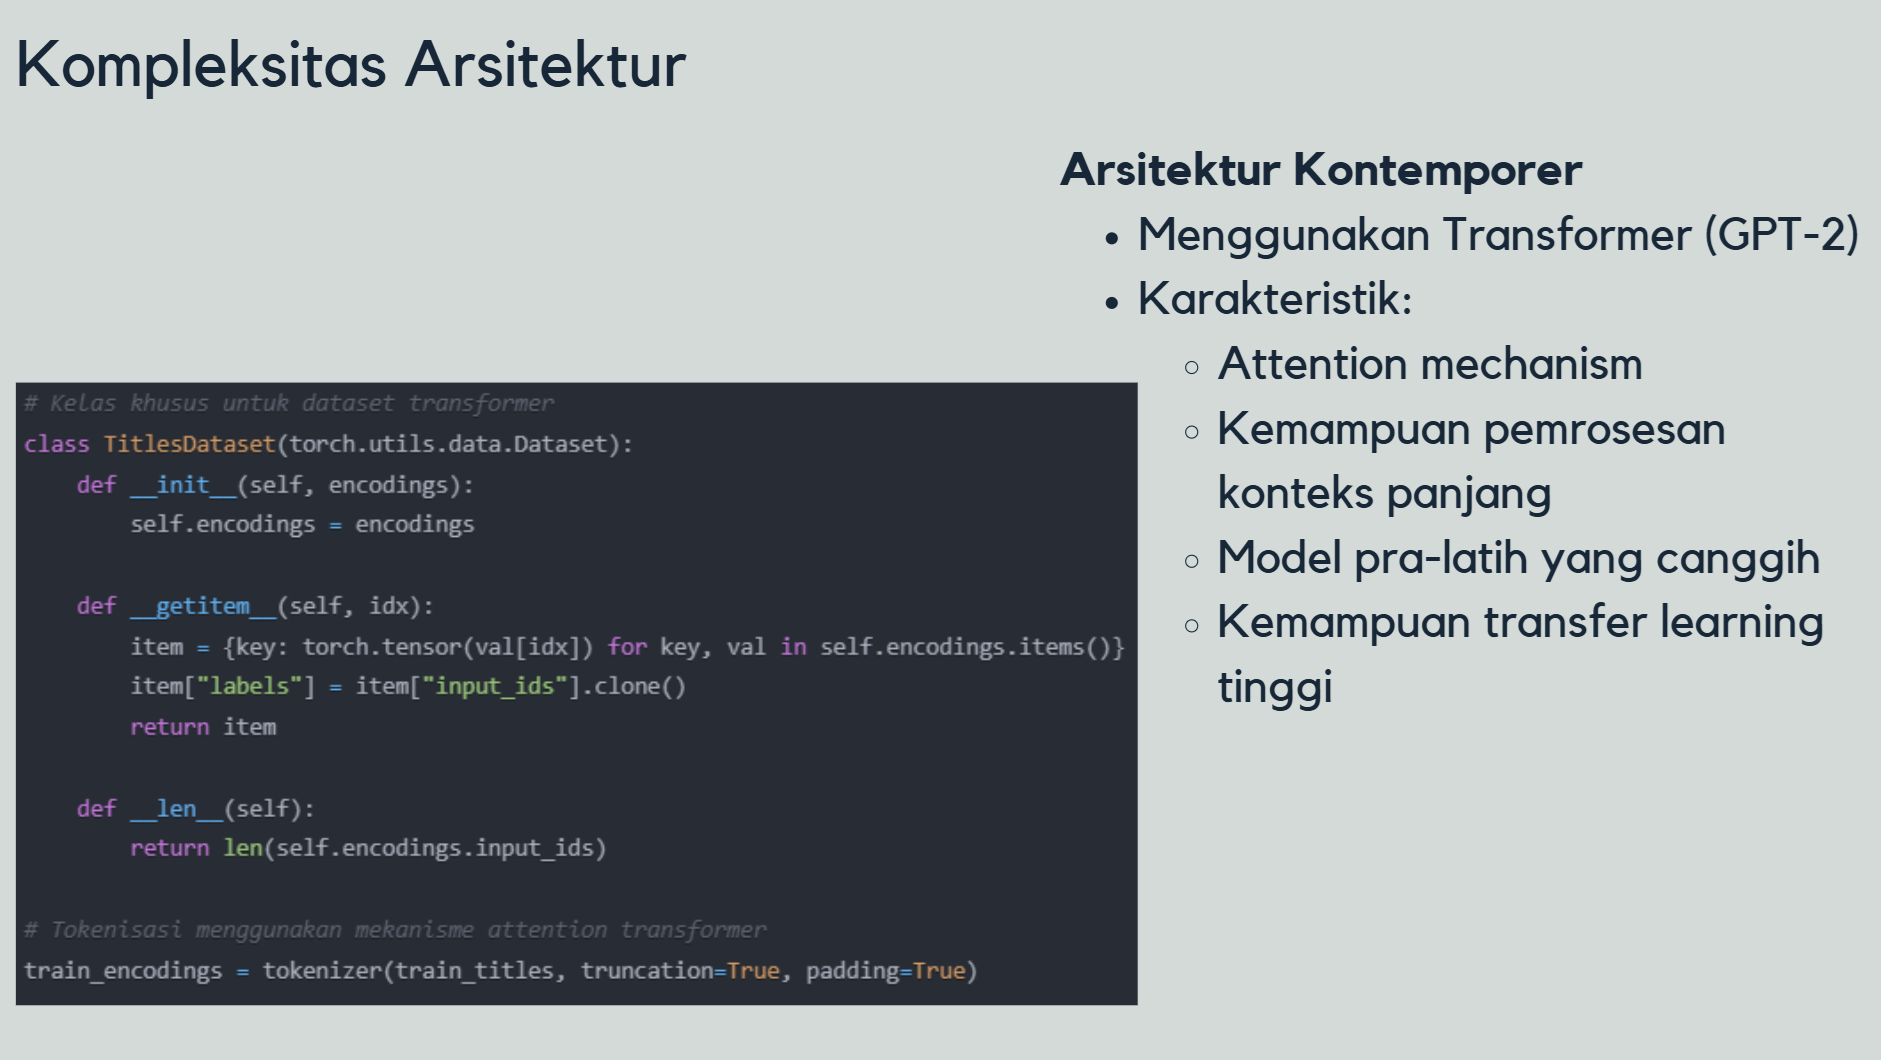

Save to drive

In [30]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copytree("QuestionableYouTubeVideoTitleV1_finetuned2", "/content/drive/My Drive/Colab_Backups/my_project")

Mounted at /content/drive


'/content/drive/My Drive/Colab_Backups/my_project'